# Contextual Search Tool ⛑

In this project, we will be using a mini BERT model (small transformer) to serve as an embedder of the action components and the dialogue components of a movie script. This will aid us in creating a ***Contextual Search Tool***.

This means you will be able to provide a summary of a particular dialogue that you faintly remember and locate it within the movie script. This tool can be applied to other types of structured text such as textbooks, legal documents, and more.

In [1]:
with open('Tenet.txt', 'r') as file:
    script_lines = file.readlines()

## Text Structure
Let's inspect how the text file containing the movie script looks. Nowadays, movie scripts follow a particular structure, which will be beneficial for identifying the different components they contain. Again, this could be applied to other documents such as novels and so on.

In [2]:
num_lines = 30
counter = 0

for line in script_lines:
    print(line, end='')
    if counter == num_lines:
      break
    else:
      counter += 1





                           TENET



                         Written by

                      Christopher Nolan



ORCHESTRA TUNING, audience settling. High officials in
glassed-in boxes toast each other. Doors closing...

BAM (from behind the orchestra) TERRORISTS with MACHINE
GUNS BURST in... The audience SCREAMS... The terrorists cover
the ordinary people... the HIGH OFFICIALS are held in the
BOXES...


INT./EXT. VAN, PLAZA, DOWNTOWN KIEV, UKRAINE (DAY)

As POLICE FLOOD THE PLAZA, the DRIVER turns to the PASSENGER


                    DRIVER
               (in Ukrainian)
          Wake up the Americans.


The components of a movie script visible in the text above include:

1. **Movie Information**:
   - **Movie Title**: "TENET"
   - **Written By**: Indicates the writer of the script, in this case, Christopher Nolan.

2. **Action Descriptions**:
   - These are descriptions of what is happening on-screen. They give directors, actors, and production teams a clear idea of the visual and auditory elements of a scene. For example:
     - "ORCHESTRA TUNING, audience settling. High officials in glassed-in boxes toast each other. Doors closing..."

3. **Scene Heading**:
   - Indicates where and when a scene takes place. "INT." stands for interior, "EXT." stands for exterior. The location is specified, followed by the time of day:
     - "INT./EXT. VAN, PLAZA, DOWNTOWN KIEV, UKRAINE (DAY)"

4. **Dialogue**:
   - Lines spoken by characters are shown, along with their names above the dialogue. For example:
     - "DRIVER (in Ukrainian) Wake up the Americans."

These components and others are standard in a professional script, providing clear direction for all aspects of the movie's production, from the visual to the spoken elements.

## Scene Divider
We are looking to separate individual scenes to process them individually. This entails using a regex to locate the beginning of a scene, indicated by a scene header, which usually starts with a combination of "EXT" or "INT."

In [3]:
import re
def extract_scenes_from_script(script_text):
    scene_list = []
    current_scene_lines = []
    consecutive_blank_lines = 0

    # Regex pattern to identify scene headings with more flexibility
    scene_heading_regex = re.compile(
        r'(INT|EXT|INT/EXT|I/E|INT-EXT|EST|MONTAGE|INT./EXT|I./E|INT.-EXT)'  # Scene type keywords
        r'\.?\s+'                                    # Optional period followed by mandatory space
        r'.*$',                                      # Rest of the heading, including location and time
        re.IGNORECASE                                # Makes matching case-insensitive
    )

    for line in script_text:
        # Ignore lines with only non-alphabetic characters (e.g. page numbers)
        if not line or re.match(r'^[^a-zA-Z]*$', line):
            continue

        # Detect scene headings based on the defined regex pattern
        if scene_heading_regex.match(line.strip()):
            # If a scene is currently being captured, store it before starting a new one
            if current_scene_lines:
                scene_list.append("\n".join(current_scene_lines))
                current_scene_lines = []
            # Reset the blank line counter since a new scene is starting
            consecutive_blank_lines = 0

        # Add the current line to the scene being constructed
        current_scene_lines.append(line)

    # If there are any lines left in the last scene, add it to the scene list
    if current_scene_lines:
        scene_list.append("\n".join(current_scene_lines))

    return scene_list

Below is a scene that has been separated based on it header.

In [4]:
scenes = extract_scenes_from_script(script_lines)

In [5]:
print(scenes[7])

INT. BOX, CONCERT HALL ­ CONTINUOUS

The Protagonist BURSTS in ­ takes out the Official beside the

Well-Dressed Man ­

                    PROTAGONIST

          We live in a twilight world...

The Well-Dressed Man stares, shocked ­

                    PROTAGONIST (CONT'D)

          We live in a twilight world...

                    WELL-DRESSED MAN

               (focuses)

          And there are no friends at dusk.

                    PROTAGONIST

          You've been made. This siege is a

          blind for them to vanish you.

                    WELL-DRESSED MAN

          But I've established contact ­

                    PROTAGONIST

          Bring you in or kill you ­ I have

          two minutes. Make up your mind.

The Well-Dressed Man nods, climbs to his feet...

                    PROTAGONIST (CONT'D)

          Where's the package?

                    WELL-DRESSED MAN

          Coat check.

He hands the Protagonist a numbered ticket.



## Grouping action and dialogue components

The function below (`separate_scene`) takes a string representing a scene from the screenplay and separates its content into two distinct lists: one for descriptions and one for dialogues.

It processes the scene by iterating through each line, skipping the first line (assumed to be a header) and identifying whether each line belongs to the dialogue or description based on the presence or absence of leading spaces (structure of the screenplay). Action lines, which have no leading spaces, are accumulated into blocks, while character names and their respective dialogue lines are captured when leading spaces exceed a certain threshold.

The function ensures that dialogue is attributed correctly to the appropriate character and combines all accumulated content before returning the lists of descriptions(action component) and dialogues.

In [6]:
def separate_scene(scene):
    # Initialize lists for dialogue and descriptions
    dialogues = []
    descriptions = []

    # Split the scene by lines
    lines = scene.split('\n')

    current_description = []
    current_character = None
    current_dialogue_lines = []
    capture_dialogue = False

    for j, line in enumerate(lines):
        # Skip first line in a scene, it should be the header, not needed
        if j == 0:
            continue

        # Strip the line for processing but keep original leading spaces for classification
        stripped_line = line.strip()

        # Skip empty lines
        if not stripped_line:
            continue

        # Description lines have no leading white spaces
        if not line.startswith(" "):
            if capture_dialogue:
                # Add the current dialogue block to the dialogues list as a dictionary
                dialogues.append({current_character: '\n'.join(current_dialogue_lines)})
                capture_dialogue = False
                current_character = None
                current_dialogue_lines = []

            # Add line to the current description block
            current_description.append(stripped_line)
        else:
            # Lines with leading spaces indicate character names or dialogue
            leading_spaces = len(line) - len(line.lstrip())

            # Character name lines have more leading spaces than dialogues
            if stripped_line.isupper() and leading_spaces >= 20:  # Assuming 20 spaces for character names
                if current_description:
                    # Join accumulated description lines into a single string and add to descriptions list
                    descriptions.append(' '.join(current_description))
                    current_description = []

                if capture_dialogue:
                    # Add the current dialogue block to the dialogues list as a dictionary
                    dialogues.append({current_character: '\n'.join(current_dialogue_lines)})

                # Start a new dialogue block with the character's name
                current_character = stripped_line
                if '(' in current_character:
                    current_character = stripped_line.split('(')[0].strip()
                current_dialogue_lines = []
                capture_dialogue = True
            elif capture_dialogue and leading_spaces >= 10:  # Assuming 10 spaces for dialogue
                # Append dialogue lines under the current character name
                current_dialogue_lines.append(stripped_line)

    # Add any remaining description or dialogue block
    if current_description:
        descriptions.append('\n'.join(current_description))
    if capture_dialogue and current_character:
        dialogues.append({current_character: ' '.join(current_dialogue_lines)})

    return descriptions, dialogues

Below is an example output of the first scene in this movie script.

In [7]:
# Separate the scene
descriptions, dialogues = separate_scene(scenes[1])

# Print the results
print("Actions:")
for j, desc in enumerate(descriptions):
    print(str(j)+": "+desc)

print("\nDialogues:")
for j, dialog in enumerate(dialogues):
  for key, value in dialog.items():
    #Lets remove any non-printable characters (including \xad and \n)
    clean_value = ''.join(c if c.isprintable() else ' ' for c in value)
    print(str(j)+": "+str(key)+"->\t"+str(clean_value))

Actions:
0: As POLICE FLOOD THE PLAZA, the DRIVER turns to the PASSENGER
1: The Passenger turns to the back where four BLACK-CLAD YOUNG MEN SIT, WAITING. The nearest one seems to be SLEEPING...
2: EYES CLOSED, the young man COCKS his weapon, chambering a
round, POPS it out of the slide, CATCHES it, opens his eyes ­
this is THE PROTAGONIST...
The Passenger nods, 'okay'. The Driver looks down at a
VARIETY OF UNIFORM PATCHES...
SIRENS. The Americans shoulder WEAPONS, pull on HELMETS...
A UKRAINIAN SWAT VAN SCREECHES to a halt outside the theatre
The Passenger spots its markings ­ TOSSES the corresponding
patches to the Americans, who slap them onto their shoulders.
Ukrainian SWATs pour out of the SWAT van
The Americans JUMP out of the back of their van, SLIPPING
UNNOTICED INTO THE STREAM OF SWATS pouring into the lobby...

Dialogues:
0: DRIVER->	(in Ukrainian) Wake up the Americans.
1: PASSENGER->	Hey


## Mini Bert model for embedding
We start by importing a small bert model that is uncased (not fined tunex for anyparticular task).

In [8]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load pre-trained BERT model and tokenizer
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertModel.from_pretrained(model_name,output_hidden_states=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Types of sentence embeddings
There can be several methods for obtaining BERT embeddings for text:

1. **Mean Embedding**: Computes the mean of token embeddings from the last hidden layer, excluding padding tokens, to get a sentence-level representation.
2. **Concatenation Embedding**: Concatenates the embeddings of the [CLS] token from the last four layers of BERT to create a comprehensive representation.
3. **CLS Token Embedding**: Uses the [CLS] token embedding from the last layer of BERT as a sentence-level embedding.
4. **SEP Token Embedding**: Utilizes the [SEP] token embedding from the last hidden layer for sentence representation.

Each method provides a different approach to representing text, which we will be testing for their effectiveness.

In [9]:
# Function to get BERT embeddings for each description
# using the mean of each token embedding at berts last layer
def get_bert_mean_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    # Get the embeddings from the last hidden layer
    last_hidden_state = outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_size]

    # Mean pooling: Calculate the mean of all token embeddings (excluding [PAD] tokens)
    attention_mask = inputs['attention_mask']
    masked_embeddings = last_hidden_state * attention_mask.unsqueeze(-1)
    sentence_embedding = masked_embeddings.sum(dim=1) / attention_mask.sum(dim=1, keepdim=True)


    return sentence_embedding.squeeze().numpy()

# Function to get BERT embeddings for each description
# using the concatenation of the last four CLS token layer embeddings
def get_bert_concatenation_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    # Get the hidden states from all layers
    hidden_states = outputs.hidden_states  # Shape: [layer_count, batch_size, seq_len, hidden_size]

    # Select the last four layers
    last_four_layers = hidden_states[-4:]

    # Concatenate the layers to get a single representation
    # Concatenate the hidden states for each token across the last four layers
    concatenated_hidden_states = torch.cat(last_four_layers, dim=-1)  # Shape: [batch_size, seq_len, hidden_size * 4]

    # Take the embedding for the [CLS] token (assuming it is at index 0)
    cls_embedding = concatenated_hidden_states[:, 0, :]

    return cls_embedding.squeeze().numpy()

# Function to get BERT embeddings for each description
# using the CLS token embedding of the last bert layer
def get_bert_CLS_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    # Use the [CLS] token embedding for sentence-level embedding
    cls_embedding = outputs.last_hidden_state[:, 0, :]

    return cls_embedding.squeeze().numpy()

# Function to get BERT embeddings for each description
# using the embedning of the last none word token.
def get_bert_SEP_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    # Use the [SEP] token embedding for sentence-level embedding
    sep_embedding = outputs.last_hidden_state[:, -1, :]

    return sep_embedding.squeeze().numpy()

To test which embeding to use lets try comparing one of the previous scene descriptions (actions) to other sentences.

*   One will be an unrelated sentences to the previous actions.
*   Another is a paraphrased version of the last action within the scene
*   The final one we will use a summarization of the last action.

In [10]:
unrelated_text = '''Another word you could use is "melancholic." While it leans more toward sadness, it can still capture that mix of reflective happiness and sorrow, especially when thinking about the past or something meaningful yet fleeting.'''
paraphased_scene = '''The young man cocks his weapon, chambers a round, and catches it, then opens his eyes—he’s the protagonist. The Passenger nods; the Driver examines uniform patches. Sirens blare as the Americans don helmets and shoulder weapons. A Ukrainian SWAT van screeches to a halt outside the theater. The Passenger sees its markings and hands the patches to the Americans, who attach them. Ukrainian SWATs exit the van, and the Americans blend into the crowd entering the lobby.'''
summarized_scene = "A young man chambers a round, then opens his eyes and he's the protagonist. The Passenger and Driver prepare with their patches, while sirens blare. Ukrainian SWAT van arrives, and Americans blend in with them, slipping into the theatre lobby."

descriptions.append(unrelated_text)
descriptions.append(paraphased_scene)
descriptions.append(summarized_scene)

We do a simple test to see which of these embeddings may hold the best method to compare an action component to that of its parapharsed and summerized version.

In [11]:
def clean_text(text):
    # Remove non-printable characters (including \xad and \n)
    clean_value = ''.join(c if c.isprintable() else ' ' for c in text)
    # Remove any addition white spaces found between strings.
    clean_value = re.sub(' +', ' ', clean_value)
    # Remove any leading or trailing white spaces.
    clean_value = clean_value.strip()
    return clean_value

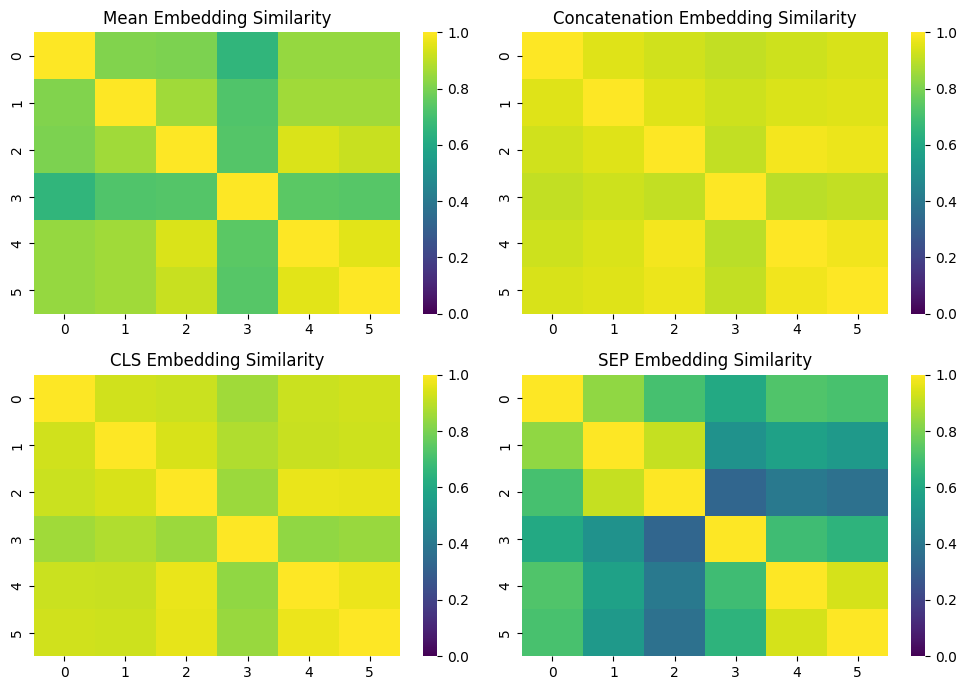

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate embeddings for all descriptions using the four methods
mean_embeddings = [get_bert_mean_embedding(clean_text(text.lower())) for text in descriptions]
concatenation_embeddings = [get_bert_concatenation_embedding(clean_text(text.lower())) for text in descriptions]
cls_embeddings = [get_bert_CLS_embedding(clean_text(text.lower())) for text in descriptions]
sep_embeddings = [get_bert_SEP_embedding(clean_text(text.lower())) for text in descriptions]

# Calculate cosine similarity matrices
mean_similarity_matrix = cosine_similarity(mean_embeddings)
concatenation_similarity_matrix = cosine_similarity(concatenation_embeddings)
cls_similarity_matrix = cosine_similarity(cls_embeddings)
sep_similarity_matrix = cosine_similarity(sep_embeddings)

# Create heatmaps with a consistent color range
fig, axes = plt.subplots(2, 2, figsize=(10, 7))

sns.heatmap(mean_similarity_matrix, vmin=0, vmax=1, cmap="viridis", ax=axes[0, 0])
axes[0, 0].set_title("Mean Embedding Similarity")

sns.heatmap(concatenation_similarity_matrix, vmin=0, vmax=1, cmap="viridis", ax=axes[0, 1])
axes[0, 1].set_title("Concatenation Embedding Similarity")

sns.heatmap(cls_similarity_matrix, vmin=0, vmax=1, cmap="viridis", ax=axes[1, 0])
axes[1, 0].set_title("CLS Embedding Similarity")

sns.heatmap(sep_similarity_matrix, vmin=0, vmax=1, cmap="viridis", ax=axes[1, 1])
axes[1, 1].set_title("SEP Embedding Similarity")

plt.tight_layout()
plt.show()


It seems from visual inspection that at least all the embedding except for the SEP embedding are doing well. The mean and Concatentaion embedding seem to really place high values between the action 2 and its paraphrased and summarized versions.



## Embedding all action and dialog compononets for this movie script.
Now we will use how this mini bert model to do a sorf of RAG model to contextually look for a particular scenes.

We start by gathering all the scenes and actions from all the movie script and embedding these to create a search up library.

We could create a kd-tree for rapid look up but simply quickly comparing the query text with that of the other embedding works pretty quickly, so there is no need for some complicated search system.

In [13]:
import time
start_time = time.time()

scene_embeddings = {}
dialogue_embeddings = {}
global_descriptions = {}
global_dialogues = {}

for scene_number in range(len(scenes)):
  descriptions, dialogues = separate_scene(scenes[scene_number])
  global_descriptions[scene_number] = descriptions
  global_dialogues[scene_number] = dialogues
  scene_embeddings[scene_number] = [get_bert_mean_embedding( clean_text(description.lower()) ) for description in descriptions]
  if dialogues:
    dialogue_embeddings[scene_number] = [get_bert_mean_embedding( clean_text(chat.get(next(iter(chat))).lower()) ) for chat in dialogues]
  else:
    dialogue_embeddings[scene_number] = []

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Time taken to embed description of each scene across all the movie script: {elapsed_time:.2f} seconds")


Time taken to embed description of each scene across all the movie script: 145.51 seconds


## Top 5 most similar action components in all of this movie script based on a query text.

In [14]:
# prompt: Given an input text, example text="I love butterflies!" embedded it through get_bert_mean_embedding then run a cosine similarity across all of the desc embeddings return the first 5 embedding scene index + desc index with the highest cosine similarity.

def get_most_similar_scenes(query_text, scene_embeddings, top_n=5):
    """
    Finds the most similar scenes to a given query text.

    Args:
        query_text: The text to find similar scenes for.
        scene_embeddings: A dictionary mapping scene numbers to lists of description embeddings.
        top_n: The number of most similar scenes to return.

    Returns:
        A list of tuples (scene_index, desc_index, similarity_score) representing the top_n most similar scenes.
    """
    query_embedding = get_bert_mean_embedding(query_text)

    results = []
    for scene_index, desc_embeddings in scene_embeddings.items():
        for desc_index, desc_embedding in enumerate(desc_embeddings):
            similarity = cosine_similarity([query_embedding], [desc_embedding])[0][0]
            results.append((scene_index, desc_index, similarity))

    # Sort results by similarity score in descending order
    results.sort(key=lambda x: x[2], reverse=True)

    # Return the top_n results
    return results[:top_n]

Printing out most cosine similar action components based on the query text.

In [15]:
import matplotlib.pyplot as plt
import textwrap

def plot_similar_scenes_with_query(most_similar_scenes, global_descriptions, query_text, wrap_width=45):
    """
    Plots the most similar scenes and query text in a 2x3 grid.

    Parameters:
        most_similar_scenes (list of tuples): List of (scene_index, desc_index, similarity).
        global_descriptions (list of lists): Descriptions of scenes.
        query_text (str): The query text to be plotted.
        wrap_width (int): The width to wrap the text. Default is 45.
    """
    # Function to wrap text
    def wrap_text(text, width=50):
        return '\n'.join(textwrap.wrap(text, width=width))

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))  # Create a 2x3 grid

    for i, (scene_index, desc_index, similarity) in enumerate(most_similar_scenes):
        row = i // 3
        col = i % 3

        action = global_descriptions[scene_index][desc_index]
        wrapped_text = wrap_text(action, width=wrap_width)
        axes[row, col].text(0.05, 0.95, wrapped_text, va='top', ha='left', fontsize=10, wrap=True)
        axes[row, col].set_title(f"Scene {scene_index}, Action {desc_index}\nSimilarity: {similarity:.3f}")
        axes[row, col].axis('off')  # Hide axes

        # Special case: after the 4th plot, add query text in red
        if i == 4:
            # Move to next cell for query text
            row = (i + 1) // 3
            col = (i + 1) % 3

            wrapped_text_query = wrap_text(query_text, width=wrap_width)
            axes[row, col].text(0.05, 0.95, wrapped_text_query, va='top', ha='left', fontsize=10, wrap=True, color='red')
            axes[row, col].set_title("Query text")
            axes[row, col].axis('off')  # Hide axes
            break  # End loop after adding query text

    plt.tight_layout()
    plt.show()

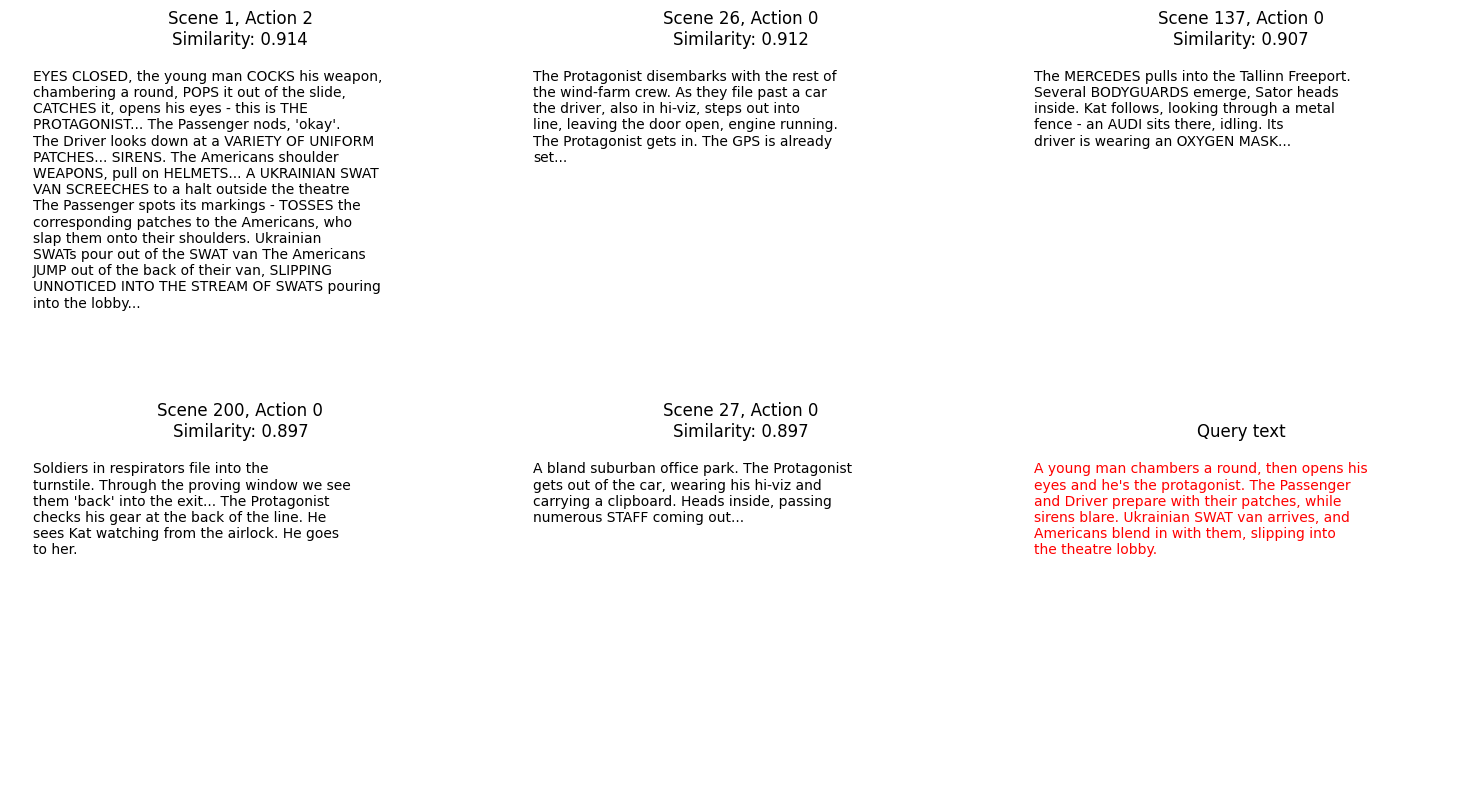

In [16]:
# Example usage 1
# Hope to find the action 2 from scene 1
query_text = "A young man chambers a round, then opens his eyes and he's the protagonist. The Passenger and Driver prepare with their patches, while sirens blare. Ukrainian SWAT van arrives, and Americans blend in with them, slipping into the theatre lobby."
most_similar_scenes = get_most_similar_scenes(query_text.lower(), scene_embeddings)
plot_similar_scenes_with_query(most_similar_scenes, global_descriptions, query_text)

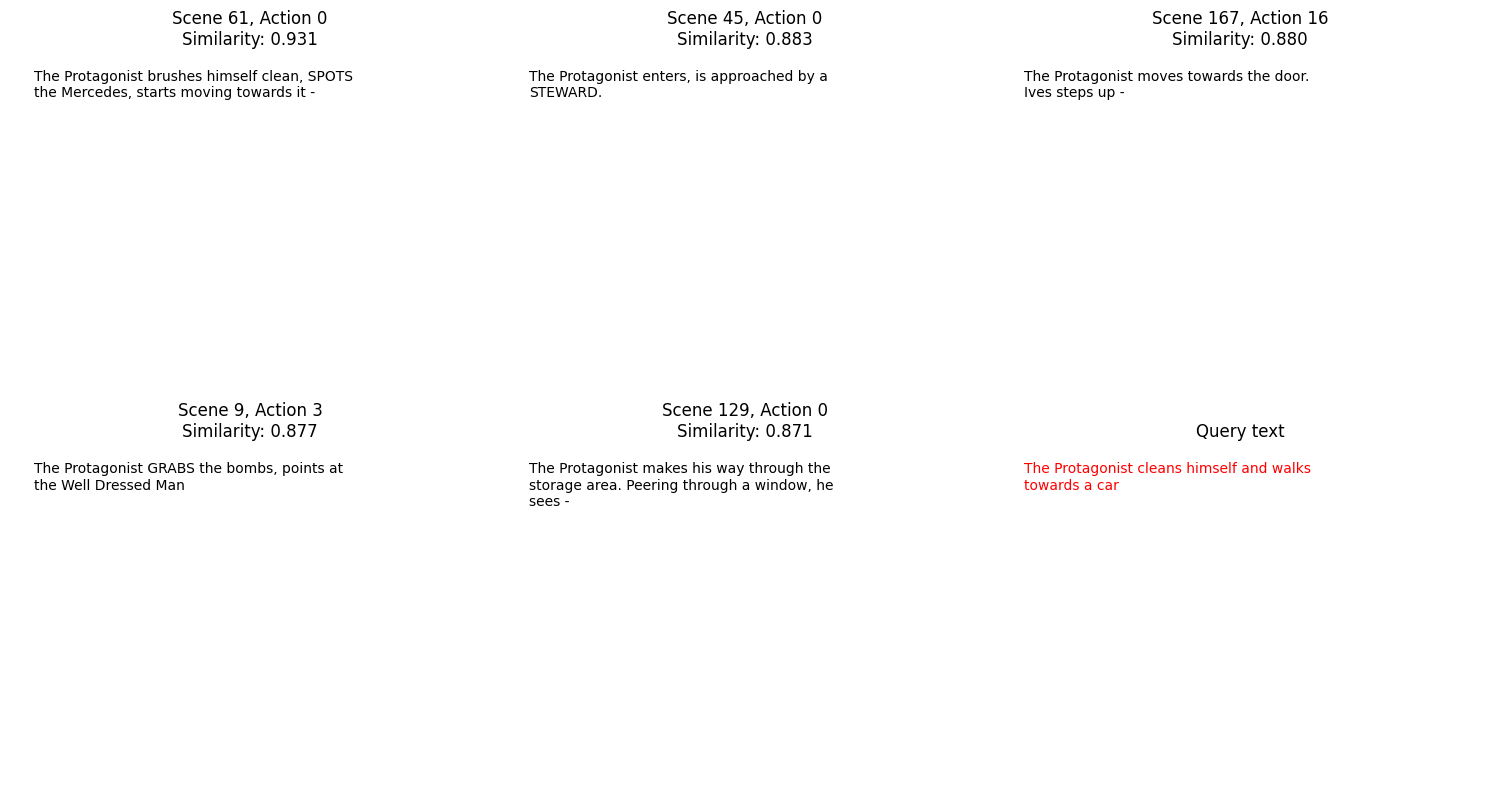

In [17]:
# Example usage 2
# Hope to find the action 0 from scene 61
query_text = "The Protagonist cleans himself and walks towards a car."
most_similar_scenes = get_most_similar_scenes(query_text.lower(), scene_embeddings)
plot_similar_scenes_with_query(most_similar_scenes, global_descriptions, query_text)

Finally we create a system to do something similar with contextual search of dialogue, in this case there are scenes with empty dialogues. The user can also provide the name of the character to improve / narrow down the search.

In [18]:
import pandas as pd

def search_dialogue(query_text, character_name=None):
    query_embedding = get_bert_mean_embedding(query_text.lower())
    most_similar_dialogues = []

    for scene_number, dialogues in dialogue_embeddings.items():
        for i, dialogue_embedding in enumerate(dialogues):
            similarity = cosine_similarity([query_embedding], [dialogue_embedding])[0][0]
            if character_name:
                # Check if the character name matches
                for character, dialogue in global_dialogues[scene_number][i].items():
                    if character_name.lower() in character.lower():
                        most_similar_dialogues.append((similarity, scene_number, i, character, dialogue))

            else:
                # No character name filter
                for character, dialogue in global_dialogues[scene_number][i].items():
                    most_similar_dialogues.append((similarity, scene_number, i, character, dialogue))

    # Sort dialogues by similarity in descending order
    most_similar_dialogues.sort(reverse=True)

    # Take the top 5 most similar dialogues
    most_similar_dialogues = most_similar_dialogues[:5]

    # Convert to a pandas DataFrame for nice grid output
    results_df = pd.DataFrame(most_similar_dialogues, columns=["Similarity", "Scene", "Dialogue Index", "Character", "Dialogue"])

    # Clean diaologue text
    results_df['Dialogue'] = results_df['Dialogue'].apply(clean_text)

    # Print the DataFrame in a nice grid format
    return results_df

In [19]:
# Example usage:
query_text = "I have two minutes. Make up your mind."
character_name = None  # Optional character name to filter results

search_dialogue(query_text, character_name)

,Similarity,Scene,Dialogue Index,Character,Dialogue
0,0.936695,7,5,PROTAGONIST,Bring you in or kill you I have two minutes. M...
1,0.857790,208,14,IVES,Need to know. And you don't. Any other stupid ...
2,0.848231,115,2,SATOR,(quiet) Don't bother. Just tell me if you've s...
3,0.841835,115,0,PROTAGONIST,"Where I'm from, you buy me dinner first."
4,0.841798,46,3,PROTAGONIST,"No, just pass on the order."


In the example above the query text is only a portion of the original diaologue and it is the diaologue with the heighest cosine similarity embedding.

At the end the diologue search used a mean emedding and the action contextual search used the concatenation embedding, showen through experimentation.

## Fine-tuning
To finish lets fine-tune the uncased distilbert model to improve the search of action components by creating further cosine similarity between the summerized action we are seeking and lower cosine similarity between the action we are not interested in.

This approach is based on contrastive learning (where the model learns to differentiate between "similar" and "dissimilar" pairs).

### Triplet Loss Equation (contrastive learning)

The **Triplet Loss** can be defined as:

$$
L = \max \left(0, \text{cosine_similarity}(\mathbf{x_a}, \mathbf{x_n}) - \text{cosine_similarity}(\mathbf{x_a}, \mathbf{x_p}) + \text{margin} \right)
$$


Where:

- \( x_a \) is the **anchor** embedding.
- \( x_p \) is the **positive** embedding (a similar or related text).
- \( x_n \) is the **negative** embedding (an unrelated text).
- \( margin \) is a hyperparameter that defines the minimum distance between the anchor-positive pair and the anchor-negative pair.

For cosine similarity we are using the embedding we already established for the searching of action components, the concatentation embedding of the last 4 CLS tokens.


In [20]:
import torch
from transformers import DistilBertTokenizer, DistilBertModel, AdamW
from torch.nn import functional as F
from torch.utils.data import DataLoader

# Define dataset with anchor, positive (summary), and negative (unrelated) pairs
class ContrastiveDataset(torch.utils.data.Dataset):
    def __init__(self, anchors, positives, negatives):
        self.anchors = anchors
        self.positives = positives
        self.negatives = negatives

    def __len__(self):
        return len(self.anchors)

    def __getitem__(self, idx):
        return self.anchors[idx], self.positives[idx], self.negatives[idx]

# Define contrastive loss function (triplet cosine loss)
def contrastive_loss(anchor_emb, positive_emb, negative_emb, margin=1.0):
    pos_similarity = F.cosine_similarity(anchor_emb, positive_emb)
    neg_similarity = F.cosine_similarity(anchor_emb, negative_emb)
    loss = torch.clamp(margin + neg_similarity - pos_similarity, min=0.0)
    return loss.mean()

# Function to get the concatenation of the last four CLS embeddings
def get_last_four_cls_embeddings(outputs):
    hidden_states = outputs.hidden_states[-4:]  # Last four layers
    cls_embeddings = [state[:, 0, :] for state in hidden_states]  # Extract [CLS] token embeddings
    concatenated_cls = torch.cat(cls_embeddings, dim=-1)  # Concatenate along the hidden dimension
    return concatenated_cls

# Tokenize inputs
def encode_batch(texts):
    return tokenizer(texts, return_tensors="pt", padding=True, truncation=True)

# Fine-tune model
def fine_tune_model(model, dataloader, epochs=3, learning_rate=5e-5):
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    model.train()  # Set model to training mode
    for epoch in range(epochs):
        total_loss = 0
        for anchor_text, positive_text, negative_text in dataloader:
            optimizer.zero_grad()

            # Tokenize and encode inputs
            anchor_inputs = encode_batch(anchor_text)
            positive_inputs = encode_batch(positive_text)
            negative_inputs = encode_batch(negative_text)

          # Get embeddings from model with hidden states
            anchor_outputs = model(**anchor_inputs)
            positive_outputs = model(**positive_inputs)
            negative_outputs = model(**negative_inputs)

            # Get concatenated CLS embeddings from the last four layers
            anchor_emb = get_last_four_cls_embeddings(anchor_outputs)
            positive_emb = get_last_four_cls_embeddings(positive_outputs)
            negative_emb = get_last_four_cls_embeddings(negative_outputs)

            # Compute loss
            loss = contrastive_loss(anchor_emb, positive_emb, negative_emb)
            total_loss += loss.item()

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader)}")

To properly define unrelated texts, the training sample should follow these:

*   **Different Content:** Unrelated texts should come from completely different scenarios (e.g., different scenes, genres, or topics).

*   **Contrastive Learning:** Make sure that the negative examples do not share a high degree of overlap with the anchor text, to ensure that the model learns to differentiate between truly dissimilar contexts. Although here it is a little difficult as many

In [21]:
# Anchors
anchors = [
    "The Protagonist RACES across the lobby, gunfire RINGING OUT LEAPS over the counter into the COAT-CHECK AREA... Landing on the floor next to an unconscious coat-check girl. He spots another bomb '4:23', '4:22'... the Protagonist checks the number on the coat-check ticket and efficiently moves across numbered racks until he finds a SPORTS BAG. He unzips it to find a BLACK METALLIC OBJECT the size of a softball. He stuffs it into his pack and SCRAMBLES over the counter...",
    "The Protagonist walks out of an electronics store, opening a new phone, and slips into the throng. He dials",
    "A WELL-DRESSED MAN sitting next to a UNIFORMED OFFICIAL looks down into the stalls people SLUMP, UNCONSCIOUS, IN A WAVE... He turns to the Official who motions calm, draws a SIDEARM...",
    "EYES CLOSED, the young man COCKS his weapon, chambering a round, POPS it out of the slide, CATCHES it, opens his eyes this is THE PROTAGONIST... The Passenger nods, 'okay'. The Driver looks down at a VARIETY OF UNIFORM PATCHES... SIRENS. The Americans shoulder WEAPONS, pull on HELMETS... A UKRAINIAN SWAT VAN SCREECHES to a halt outside the theatre The Passenger spots its markings TOSSES the corresponding patches to the Americans, who slap them onto their shoulders. Ukrainian SWATs pour out of the SWAT van The Americans JUMP out of the back of their van, SLIPPING UNNOTICED INTO THE STREAM OF SWATS pouring into the lobby...",
    "Mahir and Rohan carry crew meals through the door and into the galley, where they stack them into the catering units, supervised by a GUARD...",
    "The Protagonist and Neil walk through the terminal."
]

# Summaries
summaries = [
    "The Protagonist dodges gunfire, retrieves a black metallic object from a sports bag, and escapes over a counter in the coat-check area.",
    "The Protagonist walks out of an electronics store with a new phone and dials as he moves into the crowd.",
    "A well-dressed man witnesses people slumping unconscious as an official beside him motions for calm and draws a sidearm.",
    "A young man chambers a round, then opens his eyes and he's the protagonist. The Passenger and Driver prepare with their patches, while sirens blare. Ukrainian SWAT van arrives, and Americans blend in with them, slipping into the theatre lobby.",
    "Mahir and Rohan deliver crew meals into the galley, stacking them under the supervision of a guard.",
    "Neil and the Protagonist walk together."
]

# Unrelated texts
unrelated = [
    anchors[1],  # Unrelated for Anchor 1
    anchors[5],  # Unrelated for Anchor 2
    anchors[3],  # Unrelated for Anchor 3
    anchors[4],  # Unrelated for Anchor 4
    anchors[2],  # Unrelated for Anchor 5
    anchors[0],  # Unrelated for Anchor 5
]

In [22]:
# Prepare dataset and dataloader
dataset = ContrastiveDataset(anchors, summaries, unrelated)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Fine-tune DistilBERT model
fine_tune_model(model, dataloader, epochs=6)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Loss: 0.9724668264389038
Epoch 2, Loss: 0.8985792398452759
Epoch 3, Loss: 0.7196975151697794
Epoch 4, Loss: 0.5122286876042684
Epoch 5, Loss: 0.3502180775006612
Epoch 6, Loss: 0.24284074703852335


Save model, reload model and set it to evaluation mode, so drop out is not enacted and we get consistent results.

In [23]:
# Save the model
model.save_pretrained('./fine_tuned_distilbert')
tokenizer.save_pretrained('./fine_tuned_distilbert')
# Load the fine-tuned model and tokenizer
model = DistilBertModel.from_pretrained('./fine_tuned_distilbert')
tokenizer = DistilBertTokenizer.from_pretrained('./fine_tuned_distilbert')
model.eval()

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

Embed the old content with the newly fined tuned model.

In [24]:
import time
start_time = time.time()

scene_embeddings = {}
dialogue_embeddings = {}
global_descriptions = {}
global_dialogues = {}

for scene_number in range(len(scenes)):
  descriptions, dialogues = separate_scene(scenes[scene_number])
  global_descriptions[scene_number] = descriptions
  global_dialogues[scene_number] = dialogues
  scene_embeddings[scene_number] = [get_bert_mean_embedding( clean_text(description.lower()) ) for description in descriptions]
  if dialogues:
    dialogue_embeddings[scene_number] = [get_bert_mean_embedding( clean_text(chat.get(next(iter(chat))).lower()) ) for chat in dialogues]
  else:
    dialogue_embeddings[scene_number] = []

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Time taken to embed description of each scene across all the movie script, using fine-tunned bert model : {elapsed_time:.2f} seconds")


Time taken to embed description of each scene across all the movie script, using fine-tunned bert model : 129.61 seconds


Lets do the previous example 1 search once again and see how well it does

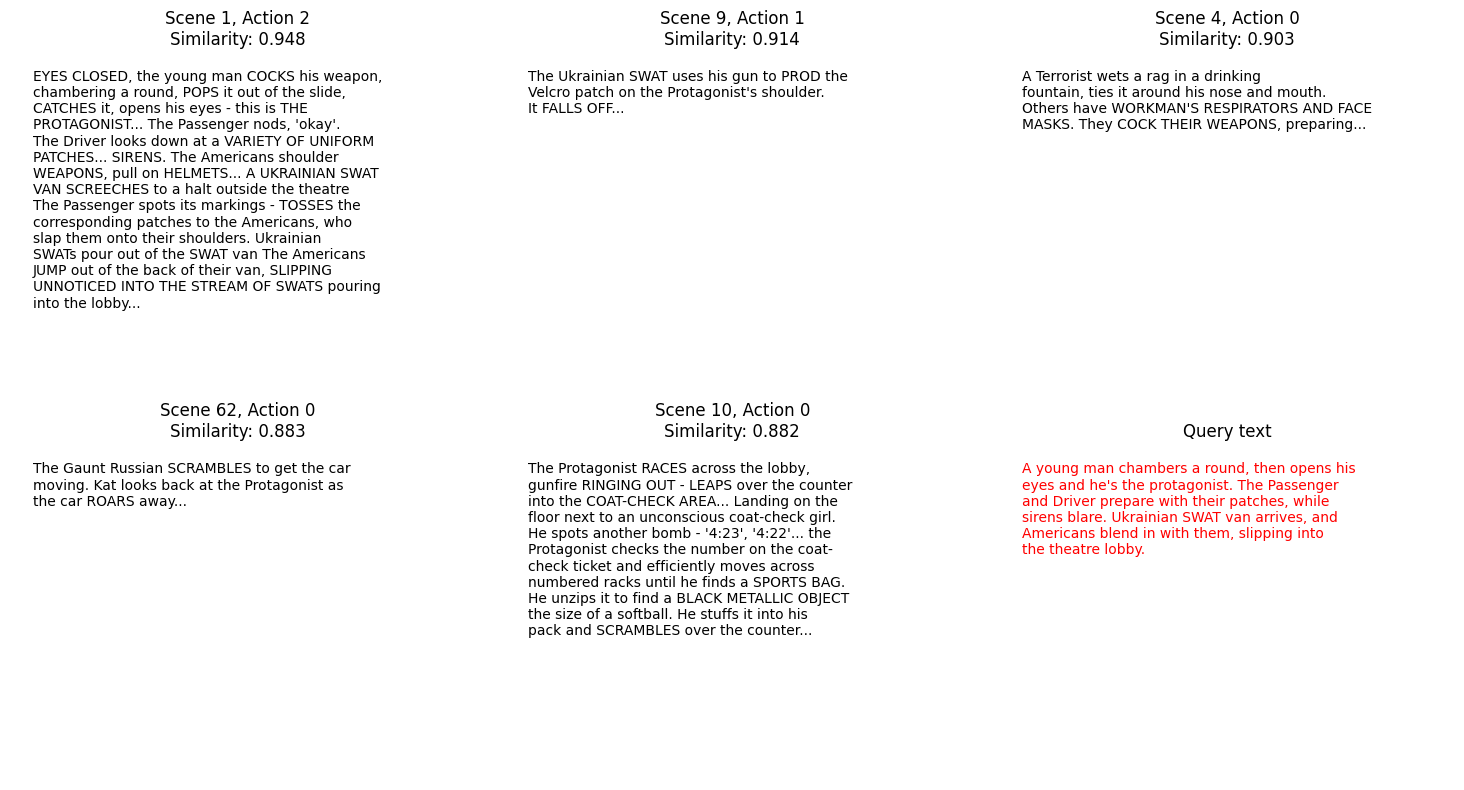

In [25]:
# Example 1 again but using the new fine-tunned model
# We hope to find the action 2 from scene 1
query_text = "A young man chambers a round, then opens his eyes and he's the protagonist. The Passenger and Driver prepare with their patches, while sirens blare. Ukrainian SWAT van arrives, and Americans blend in with them, slipping into the theatre lobby."
most_similar_scenes = get_most_similar_scenes(query_text.lower(), scene_embeddings)
plot_similar_scenes_with_query(most_similar_scenes, global_descriptions, query_text)

The diference between the intendet action component we were seeking to find and others is much larger now as compared with the untrained bert model.

Lets see how well we do with the second unseen script in the training set.

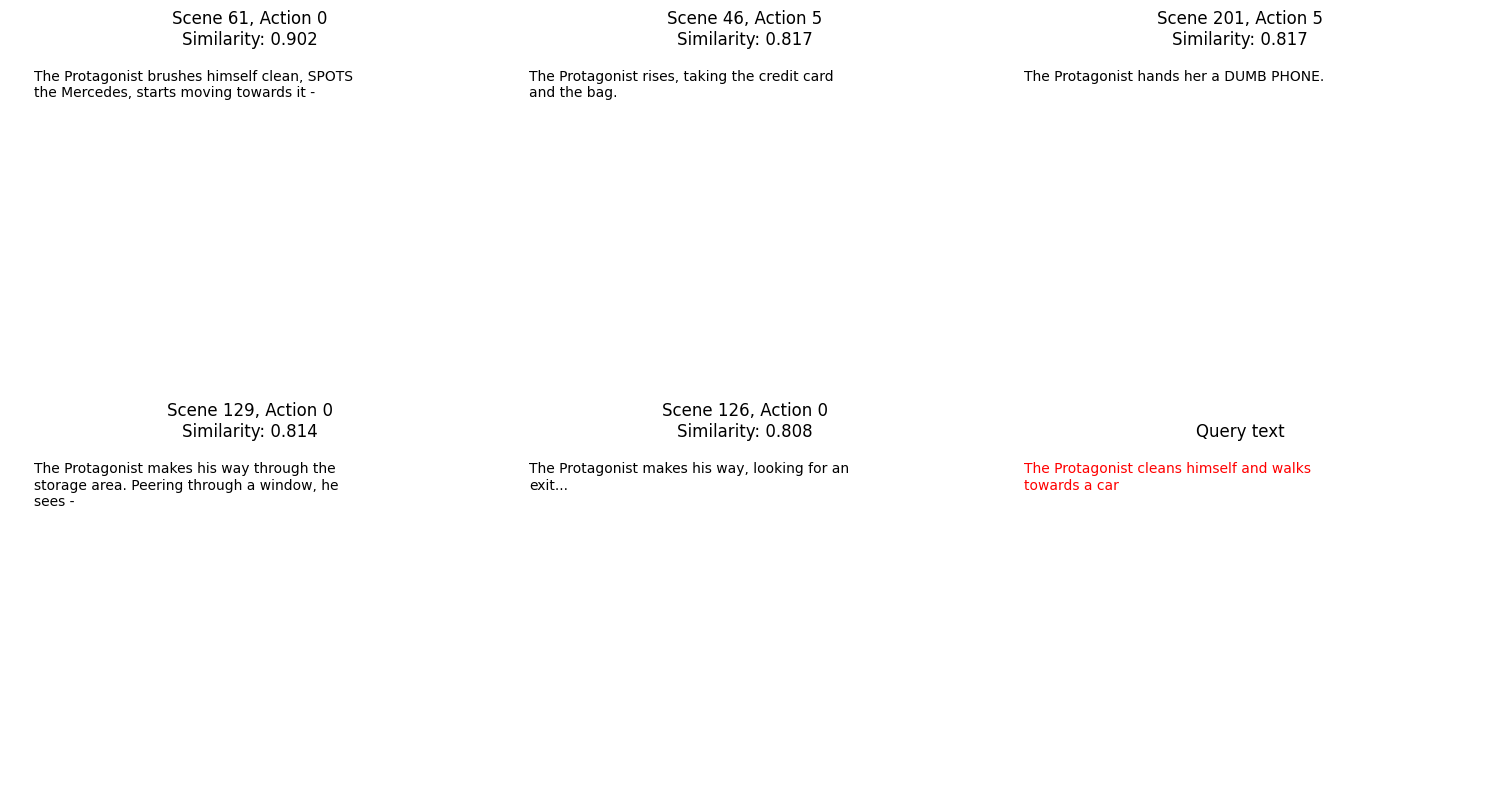

In [28]:
# Example 2 again but using the new fine-tunned model
# Hope to find the action 0 from scene 61
query_text = "The Protagonist cleans himself and walks towards a car"
most_similar_scenes = get_most_similar_scenes(query_text.lower(), scene_embeddings)
plot_similar_scenes_with_query(most_similar_scenes, global_descriptions, query_text)

Once again the diference between the first result (the one we were after) and the rest have wider gaps in cosine similarity. Demonstarting improved recognition of the action component we were after.